In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import sys
import numpy as np 
import pickle
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from tensorflow.keras.utils import to_categorical

2025-02-14 15:06:34.174770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739541994.196604   43550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739541994.205047   43550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 15:06:34.228004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
sys.path.append("/work/NLP/src")
from data.dataloaders.lstm_loader import LSTMDataLoader
from models.lstm import GloveLSTMModel
from train.lstm_trainer import LSTMTrainer
from evaluate import ModelEvaluator

In [3]:
base_dir = Path("/work/NLP/data/processed")
dataset_types = ["unprocessed", "processed"]
splits = ["train", "test", "val"]
data = {}

for dataset_type in dataset_types:
    for split in splits:
        X_key = f"X_{split}_{dataset_type}"
        y_key = f"y_{split}_{dataset_type}"
        
        data[X_key] = pd.read_csv(base_dir / f"{X_key}.csv")
        data[y_key] = pd.read_csv(base_dir / f"{y_key}.csv")

        if isinstance(data[X_key], pd.DataFrame):
            data[X_key] = data[X_key].squeeze().tolist()

X_train_unprocessed, X_test_unprocessed, X_val_unprocessed = (
    data["X_train_unprocessed"], data["X_test_unprocessed"], data["X_val_unprocessed"]
)
y_train_unprocessed, y_test_unprocessed, y_val_unprocessed = (
    data["y_train_unprocessed"], data["y_test_unprocessed"], data["y_val_unprocessed"]
)
X_train_processed, X_test_processed, X_val_processed = (
    data["X_train_processed"], data["X_test_processed"], data["X_val_processed"]
)
y_train_processed, y_test_processed, y_val_processed = (
    data["y_train_processed"], data["y_test_processed"], data["y_val_processed"]
)

# LSTM

### Data Loader

In [4]:
# Define GloVe path
glove_file = '/work/NLP/documents/glove.6B.100d.txt'

data_loader = LSTMDataLoader(glove_file=glove_file, max_words=500, max_length=400, embedding_dim=100)
X_train_padded, X_val_padded, X_test_padded, word_index = data_loader.tokenize_and_pad(X_train_unprocessed, X_val_unprocessed, X_test_unprocessed)
embedding_matrix = data_loader.embedding_matrix


 Loaded 400000 word vectors from GloVe.
Embedding matrix created.


In [5]:
embedding_matrix = embedding_matrix.astype('float32')
print("Embedding matrix shape:", embedding_matrix.shape)
print("Embedding matrix dtype:", embedding_matrix.dtype)


Embedding matrix shape: (500, 100)
Embedding matrix dtype: float32


### Model 

In [6]:
import tensorflow as tf
y_train_onehot = tf.keras.utils.to_categorical(y_train_unprocessed, num_classes=8)
y_val_onehot = tf.keras.utils.to_categorical(y_val_unprocessed, num_classes=8)

In [7]:
model = GloveLSTMModel(
     embedding_matrix=embedding_matrix,
     max_words=500,
     max_length=400,
     num_classes=8,
     embedding_dim=100
 )
model.build_model(dropout_rate=0.3, spatial_dropout=0.2, lstm_units=[128, 96], dense_units=[64], learning_rate=1e-3)




/work/NLP/myenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-14 15:07:04.029092: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
trainer = LSTMTrainer(model=model, target_names=['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s'], reports_dir="/work/NLP/reports")
trainer.train(X_train_padded, y_train_onehot, X_val_padded, y_val_onehot)


Starting LSTM training...
Epoch 1/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.1616 - loss: 2.4096

871/871 ━━━━━━━━━━━━━━━━━━━━ 496s 563ms/step - accuracy: 0.1616 - loss: 2.4093 - val_accuracy: 0.2201 - val_loss: 1.8941
Epoch 2/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.2163 - loss: 1.9247

871/871 ━━━━━━━━━━━━━━━━━━━━ 482s 554ms/step - accuracy: 0.2163 - loss: 1.9247 - val_accuracy: 0.2548 - val_loss: 1.8510
Epoch 3/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2471 - loss: 1.8571

871/871 ━━━━━━━━━━━━━━━━━━━━ 478s 549ms/step - accuracy: 0.2471 - loss: 1.8571 - val_accuracy: 0.2865 - val_loss: 1.7704
Epoch 4/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.2697 - loss: 1.8026

871/871 ━━━━━━━━━━━━━━━━━━━━ 478s 549ms/step - accuracy: 0.2698 - loss: 1.8026 - val_accuracy: 0.3014 - val_loss: 1.7398
Epoch 5/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.2989 - loss: 1.7523

871/871 ━━━━━━━━━━━━━━━━━━━━ 476s 546ms/step - accuracy: 0.2989 - loss: 1.7523 - val_accuracy: 0.3094 - val_loss: 1.7076
Epoch 6/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.3069 - loss: 1.7161

871/871 ━━━━━━━━━━━━━━━━━━━━ 475s 546ms/step - accuracy: 0.3069 - loss: 1.7161 - val_accuracy: 0.3192 - val_loss: 1.6914
Epoch 7/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 473s 543ms/step - accuracy: 0.3113 - loss: 1.6991 - val_accuracy: 0.3145 - val_loss: 1.6895
Epoch 8/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.3132 - loss: 1.6906

871/871 ━━━━━━━━━━━━━━━━━━━━ 474s 545ms/step - accuracy: 0.3133 - loss: 1.6906 - val_accuracy: 0.3291 - val_loss: 1.6850
Epoch 9/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 474s 544ms/step - accuracy: 0.3269 - loss: 1.6675 - val_accuracy: 0.3074 - val_loss: 1.7117
Epoch 10/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.3329 - loss: 1.6540

871/871 ━━━━━━━━━━━━━━━━━━━━ 474s 544ms/step - accuracy: 0.3329 - loss: 1.6540 - val_accuracy: 0.3313 - val_loss: 1.6628
Epoch 11/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.3349 - loss: 1.6486

871/871 ━━━━━━━━━━━━━━━━━━━━ 474s 544ms/step - accuracy: 0.3349 - loss: 1.6486 - val_accuracy: 0.3364 - val_loss: 1.6583
Epoch 12/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 473s 543ms/step - accuracy: 0.3349 - loss: 1.6485 - val_accuracy: 0.3318 - val_loss: 1.6453
Epoch 13/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.3472 - loss: 1.6216

871/871 ━━━━━━━━━━━━━━━━━━━━ 472s 542ms/step - accuracy: 0.3472 - loss: 1.6216 - val_accuracy: 0.3379 - val_loss: 1.6519
Epoch 14/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 473s 542ms/step - accuracy: 0.3476 - loss: 1.6128 - val_accuracy: 0.3306 - val_loss: 1.6621
Epoch 15/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 472s 542ms/step - accuracy: 0.3537 - loss: 1.5999 - val_accuracy: 0.3364 - val_loss: 1.6373
Epoch 16/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.3538 - loss: 1.6090

871/871 ━━━━━━━━━━━━━━━━━━━━ 472s 542ms/step - accuracy: 0.3538 - loss: 1.6090 - val_accuracy: 0.3381 - val_loss: 1.6682
Epoch 17/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.3595 - loss: 1.5929

871/871 ━━━━━━━━━━━━━━━━━━━━ 472s 542ms/step - accuracy: 0.3595 - loss: 1.5929 - val_accuracy: 0.3401 - val_loss: 1.6550
Epoch 18/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 472s 542ms/step - accuracy: 0.3660 - loss: 1.5793 - val_accuracy: 0.3389 - val_loss: 1.6413
Epoch 19/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 473s 543ms/step - accuracy: 0.3702 - loss: 1.5711 - val_accuracy: 0.3331 - val_loss: 1.6777
Epoch 20/20
871/871 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.3648 - loss: 1.5583

871/871 ━━━━━━━━━━━━━━━━━━━━ 472s 542ms/step - accuracy: 0.3648 - loss: 1.5583 - val_accuracy: 0.3459 - val_loss: 1.6423


249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step


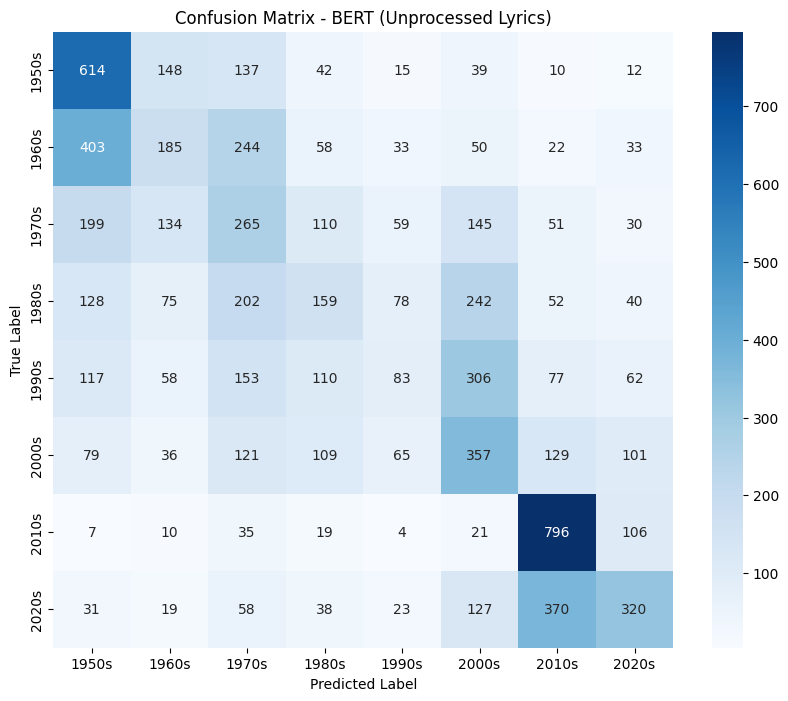

In [14]:
trainer.evaluate(X_test_padded, y_test_unprocessed)